In [2]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

# PPG preprocessing

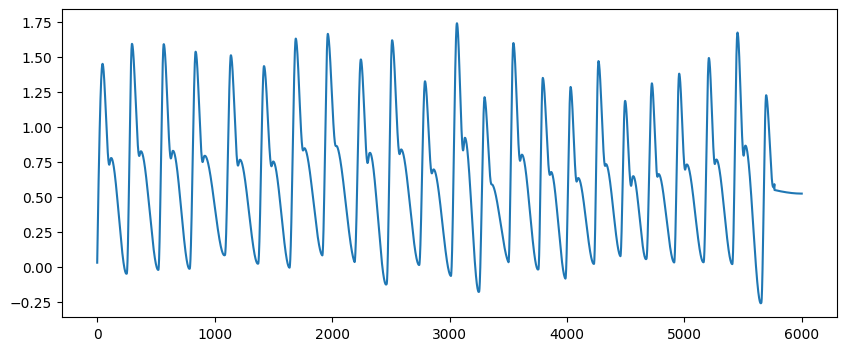

In [16]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})
plt.figure(figsize=(10,4))
plt.plot(data)

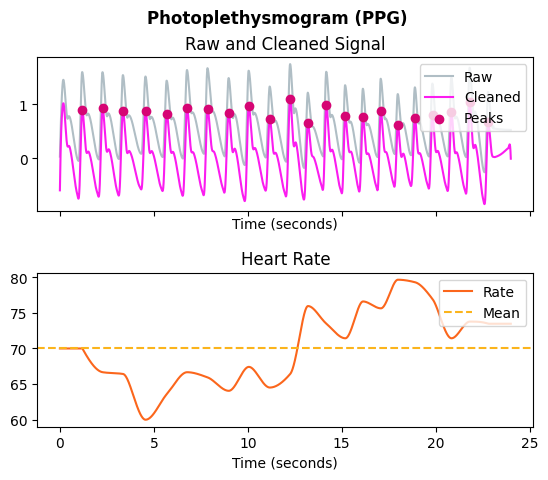

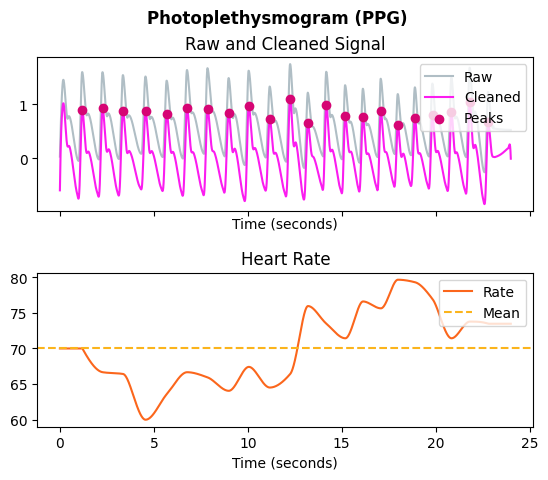

In [17]:
# Process it
signals, info = nk.ppg_process(data, sampling_rate=300)

# Visualize the processing
nk.ppg_plot(signals, sampling_rate=250)

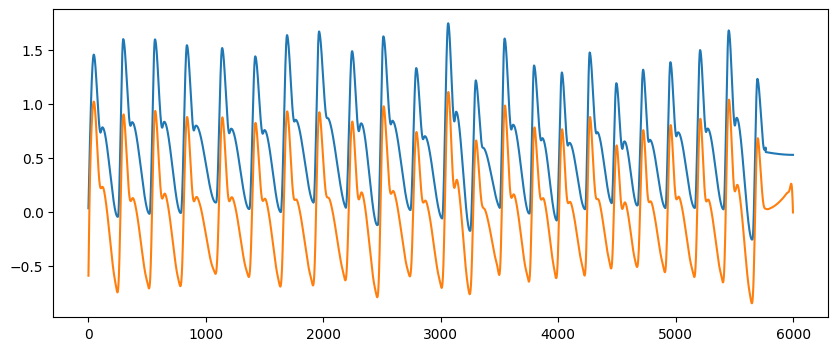

In [18]:
ppg_elgendi_clean = nk.ppg_clean(ppg, method='elgendi', sampling_rate=300)
ppg_nabian_clean = nk.ppg_clean(ppg, method='nabian2018')

signals_filtered = pd.DataFrame({'PPG_Raw' : ppg,
                        'PPG_Elgendi' : ppg_elgendi_clean,})
plt.figure(figsize=(10,4))
plt.plot(signals_filtered)


In [19]:
data = nk.data("bio_resting_5min_100hz")

event_time = []
for i in range(10):
    event_time.append(int((i/10)*len(data)))
print(event_time)

data_samp = data["PPG"]
df, info = nk.ppg_process(data["PPG"], sampling_rate=300)

# Visualize the processing
#nk.ppg_plot(df, sampling_rate=300)

epochs = nk.epochs_create(df, events=event_time, sampling_rate=100,
                          epochs_end=150)


features = nk.ppg_intervalrelated(epochs)
features_event = nk.ppg_eventrelated(epochs)
features.dropna(axis='columns')
features_event.dropna(axis='columns')
print(features)
print(features_event)

[0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000]
   Label  PPG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
1      1      99.058035  184.712500  62.345342         NaN         NaN   
2      2      95.316011  192.363636  64.160963         NaN         NaN   
3      3      91.439622  201.081081  90.875914         NaN         NaN   
4      4      91.844634  201.513514  89.874226         NaN         NaN   
5      5      94.345175  195.644737  89.911913         NaN         NaN   
6      6      97.354045  189.088608  82.915958         NaN         NaN   
7      7      80.215646  175.092308  46.057954         NaN         NaN   
8      8      64.271303  169.557692  41.515607         NaN         NaN   
9      9      43.453322  168.342857  41.453690         NaN         NaN   
10    10      21.325073  171.823529  41.438562         NaN         NaN   

    HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  ...  HRV_SampEn  \
1          NaN         NaN         NaN         NaN

Text(0, 0.5, '$EDA$')

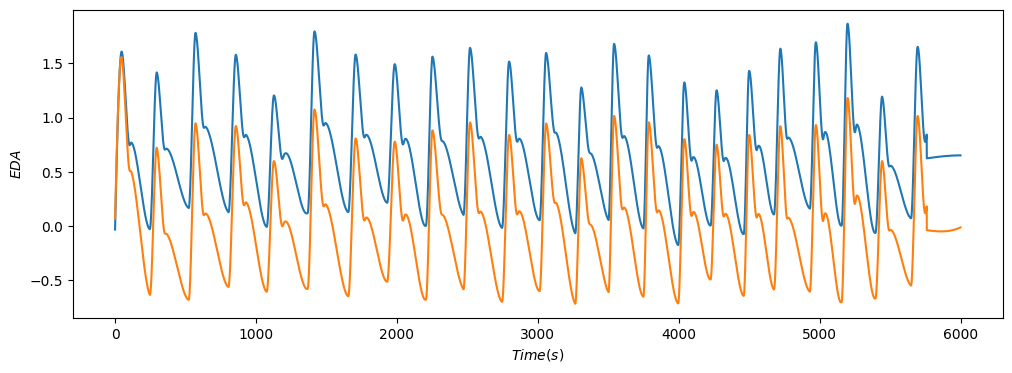

In [20]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})

############ lowpass filtering
# Parameters 
order = 5
frequency = 0.3
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).


# Filtering
b, a = scipy.signal.butter(order, frequency, btype='high')
eda_lp = scipy.signal.filtfilt(b, a, ppg)

# plot
plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(eda_lp)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

# BVP data

In [346]:
def bvp_feat(data):
    #event_time = []
    features_bvp = None

    #for i in range(samples):
    #    event_time.append(int((i/samples)*len(data)))

    df, info = nk.ppg_process(data, sampling_rate=100)

    # Visualize the processing
    #nk.ppg_plot(df, sampling_rate=fs)

    epochs = nk.epochs_create(df, events=[0,5000,10000,15000],
                         epochs_start=0, epochs_end=5)

    features_event = nk.ppg_eventrelated(epochs)
    features = nk.ppg_intervalrelated(df)

    features_event.reset_index(drop=True, inplace=True)

    features_bvp = pd.concat([features_event, features], axis = 1)
    features_bvp = features_bvp.dropna(axis='columns')
    return features_bvp

In [347]:
def bvp_prep(data):
    data = data.dropna(axis='columns')
    features = data
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features = features.dropna(axis='columns')
    features.drop(columns=features.columns[:2], axis=1,  inplace=True)
    features = features.reset_index()
    return features

In [348]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                #assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [354]:
# Set up empty dataframes for the features
fs = 700 # sampling frequency
y = []
features_bvp_df = None

data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
#data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
#data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

for i in range(1): # 15 subjects
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(subject)
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        wrist_data_dict = obj_data[subject].get_wrist_data()
        wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}

        # Get labels
        labels = obj_data[subject].get_labels()

        for label in [1,2,4]: # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])
            baseline = baseline * 64 // fs
            bvp_base=wrist_data_dict['BVP'][baseline,0] # Select the BVP data
            duration = 25

            # Multiple smaller samples per signal
            samples = 10 # specify amount of samples
            
            for j in range(samples):

                # adding the labels to y
                if label==1 or label==4: # if amusement or medidation, classify as non-stress
                    y.append(0)
                else:
                    y.append(1)

                #bvp = bvp_base[int(len(bvp_base)* (j/samples)) : int(len(bvp_base)* ((j+1)/samples))]
                # choosing a random begin point for smaller sample
                begin = random.randint(0, min(len(bvp_base),len(bvp_base))- duration * fs)

                bvp = bvp_base[begin: begin + duration*fs]
                features_bvp = bvp_feat(bvp)
                features_bvp_df = pd.concat([features_bvp_df, features_bvp], axis = 0)

S2


# PPG sample data

In [2]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

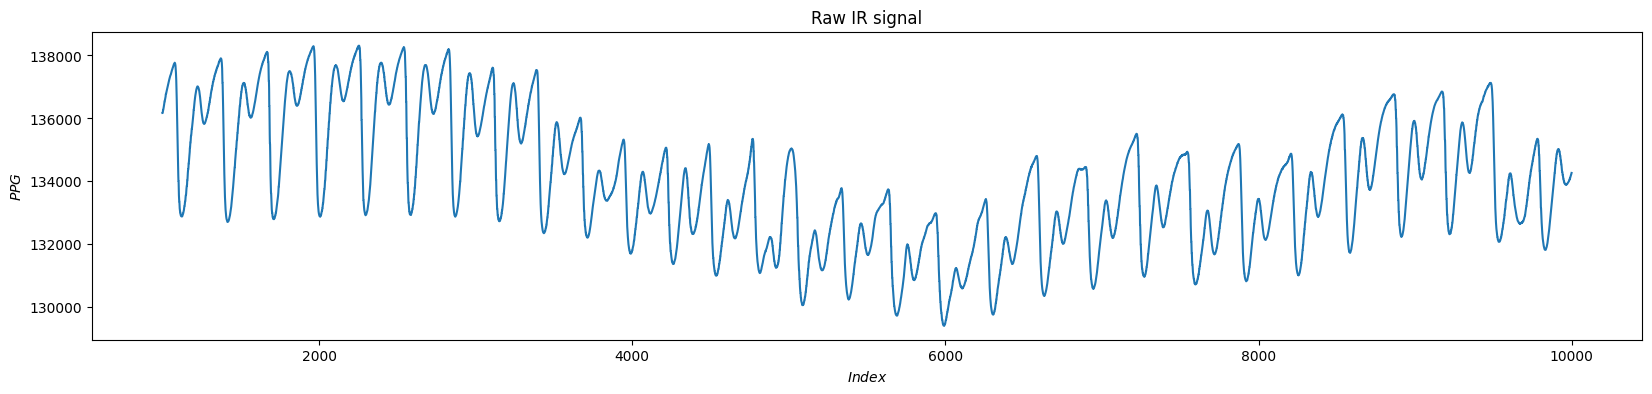

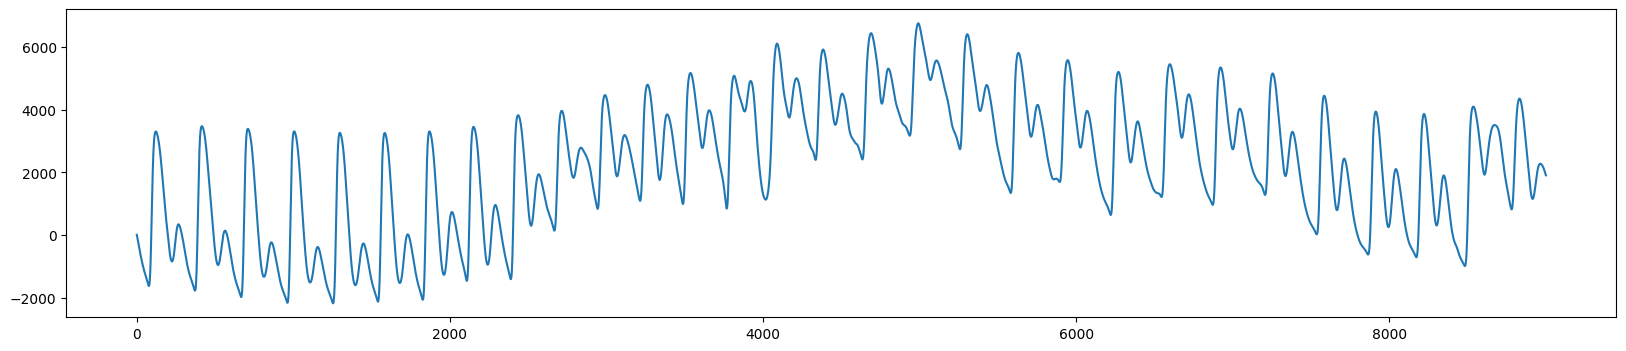

In [241]:
PPG_data = pd.read_csv('C:/Users/JackC/Documents/EPO4-C2/Testday_2/Subject_1/Nicky-nultest_1.csv')
# daan quiz & rest 1
fs = 400

red_data = PPG_data.iloc[1000:10000,[3]]
ir_data = PPG_data.iloc[1000:10000,[4]]

plt.figure(figsize=(20,4))
plt.plot(red_data)
#plt.plot(ir_data)

red_data_clean = nk.ppg_clean(red_data, method='nabian2018', sampling_rate=1000)
ir_data_clean = nk.ppg_clean(ir_data, method='nabian2018', sampling_rate=1000)
ir_data_clean = nk.ppg_clean(ir_data_clean, method='nabian2018', sampling_rate=1000)

# labels and titles
plt.title('Raw IR signal')
plt.xlabel('$Index$') 
plt.ylabel('$PPG$') 
plt.figure(figsize=(20,4))
#plt.savefig("FawIRSignal.pdf", format="pdf", bbox_inches="tight")


plt.plot(red_data.iloc[0,0] - red_data_clean)
#plt.plot(ir_data.iloc[0,0] - ir_data_clean)


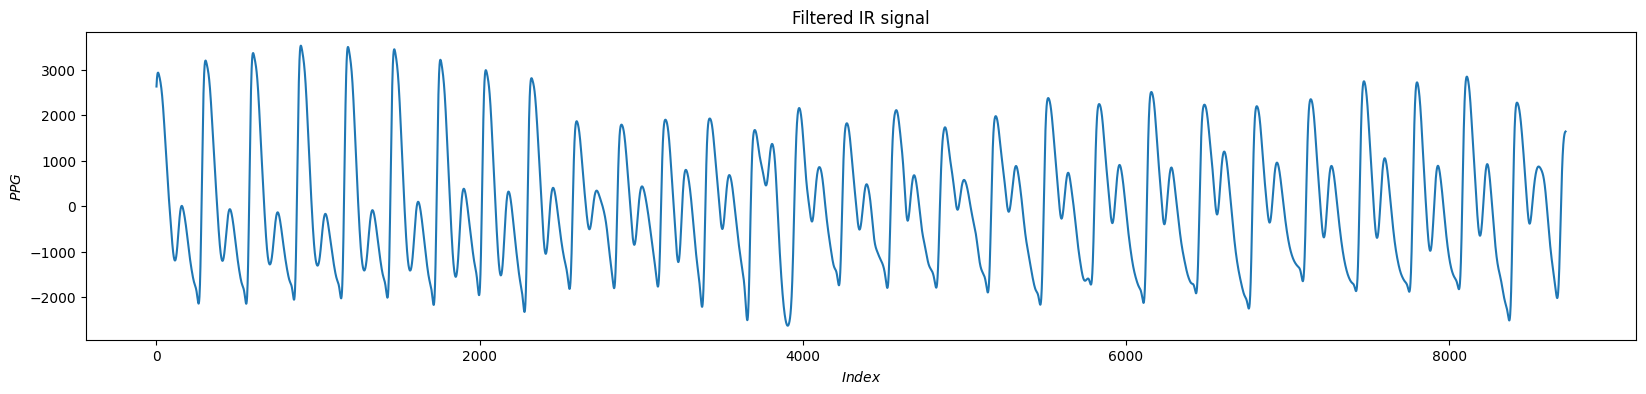

In [243]:
# Parameters 
order = 4
frequency = np.array([0.5,10])
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='band')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)[peaks_red_min[0]-10:peaks_red_min[-1]]
peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot((red_data-red_data.iloc[0,0]))
plt.plot(-red_filt)
#plt.plot(peaks_red, red_filt[peaks_red], "x")
#plt.plot(peaks_red_min, red_filt[peaks_red_min], "x")
# labels and titles
plt.title('Filtered IR signal')
plt.xlabel('$Index$') 
plt.ylabel('$PPG$') 

plt.savefig("FilterIRSignal.pdf", format="pdf", bbox_inches="tight")

In [315]:
print(bvp.size)

17500


In [356]:
df, info = nk.ppg_process(-red_filt, sampling_rate=100)
epochs = nk.epochs_create(df, events=[0,5000,10000,15000],
                         epochs_start=0, epochs_end=5)

In [357]:
print(epochs)

{'1':               PPG_Raw    PPG_Clean   PPG_Rate  PPG_Peaks  Index Label
0.000000  2630.013013   216.099567  40.627227        0.0      0     1
0.001000  2701.722353   874.964161  40.627227        0.0      1     1
0.002000  2761.926412  1384.893849  40.627227        0.0      2     1
0.003001  2811.413254  1735.438322  40.627227        0.0      3     1
0.004001  2851.054013  1938.380221  40.627227        0.0      4     1
...               ...          ...        ...        ...    ...   ...
4.995999   570.724081   234.051009  39.169271        0.0   4995     1
4.996999   574.110609   250.639468  39.255225        0.0   4996     1
4.998000   576.182398   266.025269  39.342433        0.0   4997     1
4.999000   576.981703   280.251798  39.430914        0.0   4998     1
5.000000   576.553493   293.365113  39.520685        0.0   4999     1

[5000 rows x 6 columns], '2':              PPG_Raw   PPG_Clean   PPG_Rate  PPG_Peaks  Index Label
0.000000  574.944701  305.413184  39.611763        0.0 

In [359]:
analyze_df = nk.ppg_intervalrelated(df)

In [361]:
analyze_df = bvp_prep(analyze_df)
print(analyze_df)

   index   HRV_SDNN  HRV_RMSSD   HRV_SDSD  HRV_CVNN  HRV_CVSD  HRV_MedianNN  \
0      0  23.125556  34.200564  34.505844  0.156588  0.231579         142.0   

   HRV_MadNN  HRV_MCVNN  HRV_IQRNN  ...  HRV_DFA_alpha1_DimRange  \
0    13.3434   0.093968       26.0  ...                 0.773289   

   HRV_DFA_alpha1_DimMean  HRV_ApEn  HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  \
0                 0.70811  0.415342     0.67634    4.909571     0.704452   

     HRV_CD  HRV_HFD   HRV_KFD   HRV_LZC  
0  1.100241  1.88284  3.274361  0.920983  

[1 rows x 54 columns]


C:\Users\JackC\AppData\Local\Temp\ipykernel_11388\428782265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.replace([np.inf, -np.inf], np.nan, inplace=True)


In [314]:
print(analyze_df.columns)

Index(['PPG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1',
       'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD',
       'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN',
       'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_HTI',
       'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF',
       'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2',
       'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified',
       'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI',
       'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a',
       'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca',
       'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_DFA_alpha1_ExpRange',
       'HRV_DFA_alpha1_ExpMean', 'HRV_DFA_alpha1_DimRange',
       'HRV_DFA_alpha1_DimMean', 'HRV_ApEn', 'HRV_SampEn', 'HRV_ShanEn',
       'HRV_FuzzyEn', 'HRV_MSE', 'HRV_CMSE', 'HRV_RCMSE'

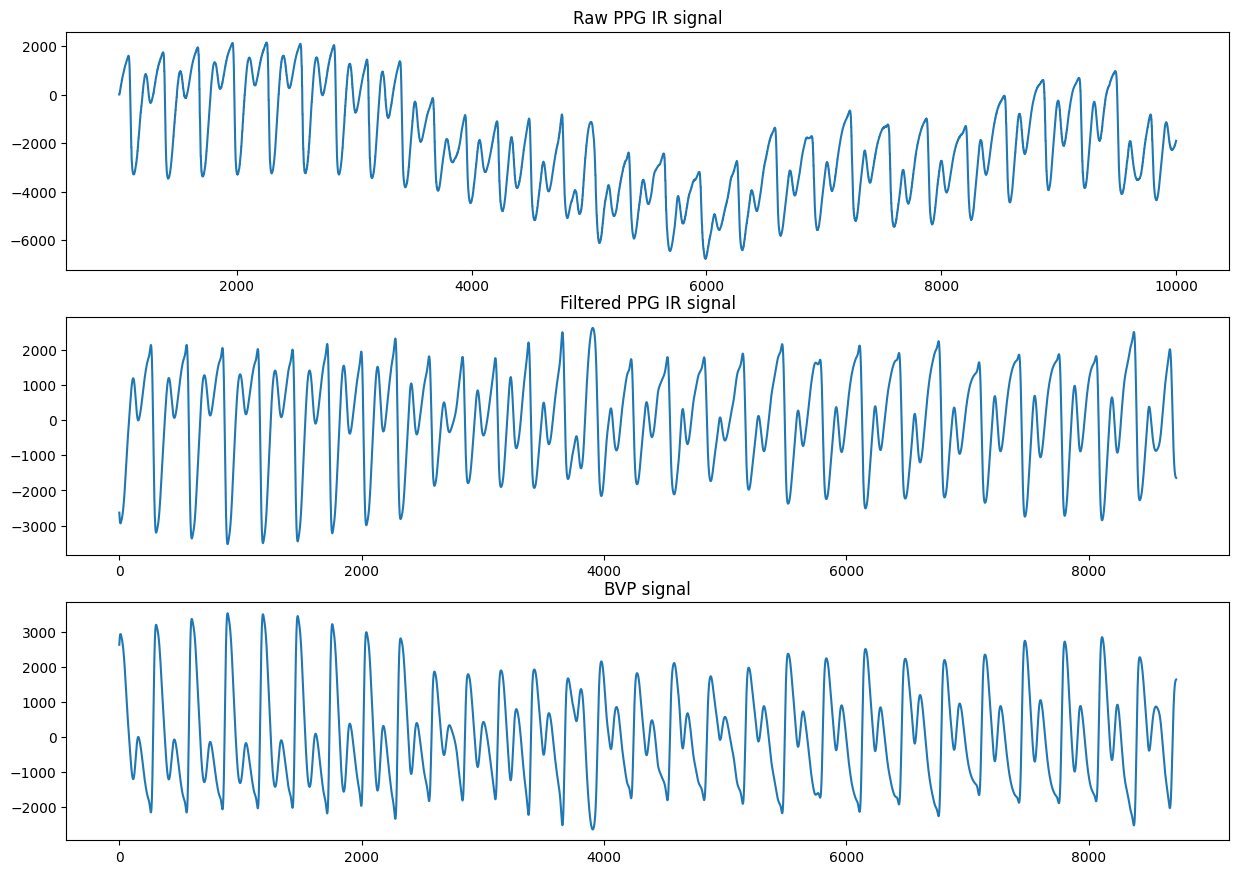

In [234]:
fig, axs = plt.subplots(3, figsize=(15, 10.5))

axs[0].plot(red_data-red_data.iloc[0,0])
axs[0].set_title('Raw PPG IR signal')
axs[1].plot(red_filt)
axs[1].set_title("Filtered PPG IR signal")
axs[2].plot(-red_filt)
axs[2].set_title("BVP signal")
plt.savefig("IRsignals.pdf", format="pdf", bbox_inches="tight")

In [15]:
red_filt_df = pd.DataFrame(red_filt)
AC_red = red_filt[peaks_red][:] - red_filt[peaks_red_min][:]
print(np.mean(AC_red))
print(AC_red.shape)

4304.876226289855
(43,)


In [16]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

DC_red = red_filt

Text(0, 0.5, '$EDA$')

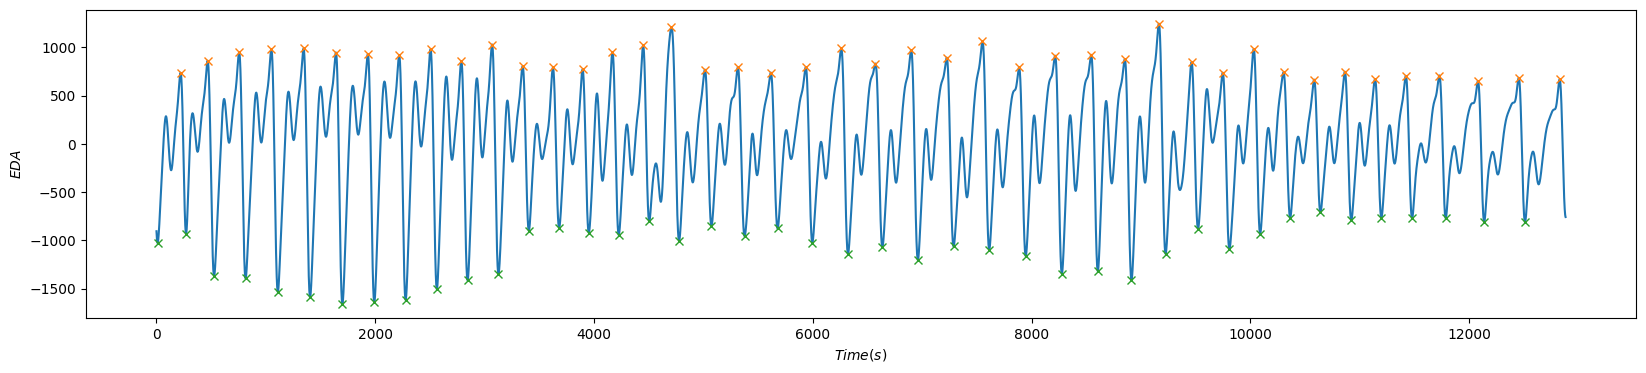

In [17]:
# Parameters 
order = 4
frequency = np.array([0.5,5])
#frequency = 0.5
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='bandpass')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

peaks_ir, _ = find_peaks(ir_filt, height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)[peaks_ir_min[0]-10:peaks_ir_min[-1]]
peaks_ir, _ = find_peaks(np.array(ir_filt), height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot(ir_data-ir_data.iloc[0,0])
#plt.plot(ir_filt)
plt.plot(ir_filt)
plt.plot(peaks_ir, ir_filt[peaks_ir], "x")
plt.plot(peaks_ir_min, ir_filt[peaks_ir_min], "x")
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

In [18]:
AC_ir = ir_filt[peaks_ir][:] - ir_filt[peaks_ir_min][:]
print(AC_ir)

[1763.56299406 1791.75576431 2315.87546849 2371.60159104 2521.11116078
 2534.8643218  2586.22015047 2554.72553671 2595.49904466 2361.90487355
 2441.697399   2153.04899075 1689.51269958 1641.11621428 1870.35864646
 1963.97546831 2013.6501807  1771.4843107  1643.12930651 1693.53749332
 1671.08460877 2012.99315957 1971.94649069 2040.04354023 2096.35990995
 2125.03777603 1886.51173561 2073.84763067 2266.18466103 2194.40607403
 2652.69900987 1984.37155778 1616.23040258 2071.37598537 1669.96056452
 1430.62216442 1458.17787157 1463.96538237 1468.28869584 1480.61982534
 1419.96821895 1491.42193287 1478.5887374 ]


In [19]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

DC_ir = ir_filt

In [20]:
DC_mean_red_l = np.empty(0)
DC_mean_ir_l = np.empty(0)
for i in range(peaks_red_min.size):
    DC_mean_red = np.mean(DC_red[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_red_l = np.append(DC_mean_red_l, DC_mean_red)
    DC_mean_ir = np.mean(DC_ir[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_ir_l = np.append(DC_mean_ir_l, DC_mean_ir)

print(DC_mean_red_l.shape)
print(DC_mean_ir_l.shape)

(43,)
(43,)


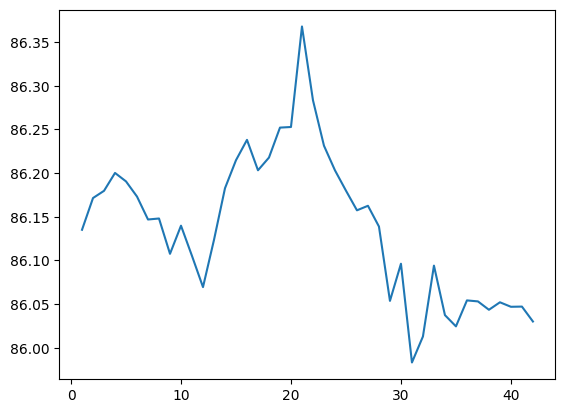

In [21]:
R = (AC_red[:] - DC_mean_red_l[:]) / (AC_ir[:] - DC_mean_ir_l[:])
SPO2 = 104 - 17 * R

plt.plot(SPO2)